<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<br>
<font size=6>
Homework 1.2
</font><br>
<font size=4>
Deep learning method
</font>

**First-Name:** Javad

**Last-Name:** Razi Giglou

**Student-Id:** 401204354

# Download Data

##### Execute the cell below to download the data required for your homework.

In [1]:
%pip install gdown
%pip install scikit-image
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1-2zT-_bKjN2o2QxwSviFwbCzcWE2PnkJ'

output = 'dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-2zT-_bKjN2o2QxwSviFwbCzcWE2PnkJ
From (redirected): https://drive.google.com/uc?id=1-2zT-_bKjN2o2QxwSviFwbCzcWE2PnkJ&confirm=t&uuid=040fff1d-afad-4067-883c-25f8b5b3ad0a
To: /home/jovyan/workspace/dataset.zip
 80%|███████▉  | 294M/368M [00:02<00:00, 116MB/s]  [Errno 28] No space left on device
 80%|████████  | 295M/368M [00:02<00:00, 126MB/s]


In [3]:
! unzip -u -q dataset.zip

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


# Import

In [4]:
import os
import numpy as np
import seaborn as sns
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
import torch
import random
import pandas as pd
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

# Config

In [5]:

RANDOM_SEED = 42 # Must be used wherever can be used

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load and Process Data

##### This dataset contains brain MRI images and manual FLAIR abnormality segmentation masks, where each pixel value of masks indicates the presence or absence of cancer (0 and 1, respectively). The images correspond to 110 patients whose IDs are available in the patient_ids.csv file.


In [7]:
data = pd.read_csv('patient_ids.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      110 non-null    object
dtypes: object(1)
memory usage: 1008.0+ bytes


In [8]:
data.head()

,id
0,TCGA_CS_4941
1,TCGA_CS_4942
2,TCGA_CS_4943
3,TCGA_CS_4944
4,TCGA_CS_5393



### **Exercise 1 (5 points)**:

##### Please use the patient_ids.csv file and the images inside the mri_scans folder to generate a Pandas dataframe named mri_df. This dataframe should have columns labeled "patient_id", "image_path", and "mask_path".

In [9]:
import glob

mri_df = pd.DataFrame()
mri_df['patient_id'] = data['id']

# Use glob to match the file paths
mri_df['image_path'] = mri_df['patient_id'].apply(lambda patient_id: glob.glob(f'./mri_scans/{patient_id}_*/*[!_mask].tif'))
mri_df['mask_path'] = mri_df['patient_id'].apply(lambda patient_id: glob.glob(f'./mri_scans/{patient_id}_*/*_mask.tif'))

# Flatten the lists
mri_df = mri_df.explode('image_path')
mri_df = mri_df.explode('mask_path')

# assert len(mri_df) == 3929
mri_df.head()



,patient_id,image_path,mask_path
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...



### **Exercise 2 (3 points)**:

##### Append a has_cancer column to the mri_df DataFrame, with values 0 indicating the absence of cancer and 1 indicating the presence of cancer. Then, convert the column to string type.

In [10]:
def is_cancerous(mask_path):
    mask = io.imread(mask_path)
    return int(np.any(mask))

mri_df['has_cancer'] = mri_df['mask_path'].apply(lambda x: is_cancerous(x))
mri_df.head()


,patient_id,image_path,mask_path,has_cancer
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,1
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,0
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,0
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,0
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,0


# Exploratory Data Analysis


### **Exercise 3 (1 points)**:

##### Calculate the number of images exhibiting the presence and absence of cancer.

In [11]:
cancer_counts = mri_df['has_cancer'].value_counts()
cancer_counts

0    108774
1     56725
Name: has_cancer, dtype: int64


### **Exercise 4 (3 points)**:

##### Determine the proportion of pixels designated as cancerous in relation to the total pixel count. Perform this calculation first for all MRI images and subsequently for images displaying signs of cancer.

In [12]:
def count_pixels(mask_path):
    mask = io.imread(mask_path)
    return np.count_nonzero(mask), np.size(mask)

pixel_counts = mri_df['mask_path'].apply(lambda x: count_pixels(x))
cancerous_pixels_count = np.sum([x[0] for x in pixel_counts])
total_pixels_count = np.sum([x[1] for x in pixel_counts])

print(f'The proportion of cancerous pixels = {100 * cancerous_pixels_count / total_pixels_count}%')
print(f'The proportion of non-cancerous pixels = {100 * (total_pixels_count - cancerous_pixels_count) / total_pixels_count}%')

The proportion of cancerous pixels = 0.9682372636037689%
The proportion of non-cancerous pixels = 99.03176273639623%


# Visualization

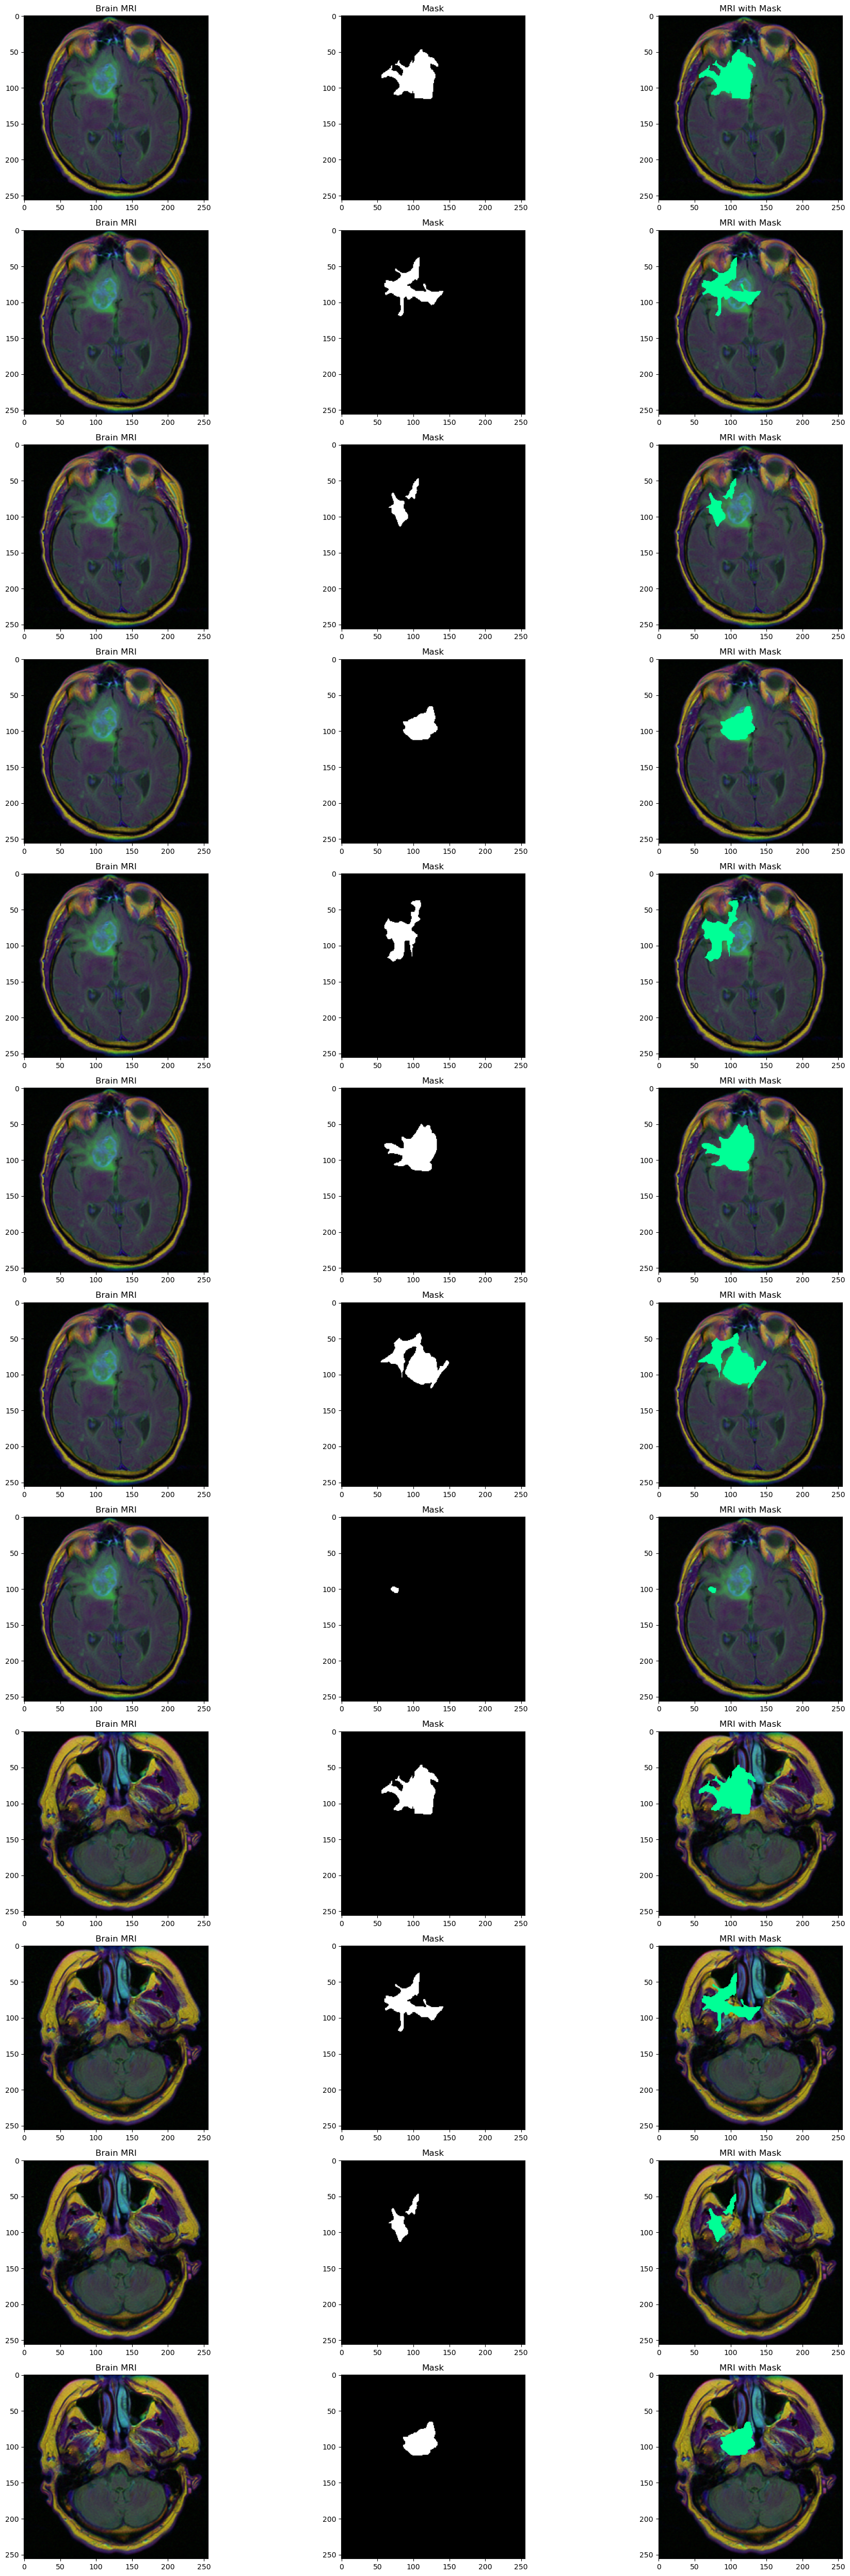

In [13]:
import matplotlib.pyplot as plt

count = 0
fig, axs = plt.subplots(12, 3, figsize=(20, 50))

for idx, row in mri_df.iterrows():
    if row['has_cancer'] == 1:
        img = io.imread(row['image_path'])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(row['mask_path'])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        img[mask == 255] = (0, 255, 150)
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count += 1

    if count == 12:
        break

fig.tight_layout()
plt.show()


# Create Dataset & DataLoader

#### Splitting To Train/Test/Val

##### Also, you are free to modify the below code.

In [14]:
# Create Dataset & DataLoader
from sklearn.model_selection import train_test_split

# Splitting To Train/Test/Val
mri_df['has_cancer'] = mri_df['has_cancer'].apply(lambda x: str(x))

X_train, X_test, y_train, y_test = train_test_split(
    mri_df[['image_path']],
    mri_df[['has_cancer']],
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify = mri_df['has_cancer'],
)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(
    train_df[['image_path']],
    train_df[['has_cancer']],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify = train_df['has_cancer']
)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)

print(f'train df count: {len(train_df)}')
print(f'test df count: {len(test_df)}')
print(f'validation df count: {len(val_df)}')

train df count: 119159
test df count: 16550
validation df count: 29790


In [15]:
print(train_df['has_cancer'].value_counts())
print(val_df['has_cancer'].value_counts())
print(test_df['has_cancer'].value_counts())

0    78317
1    40842
Name: has_cancer, dtype: int64
0    19580
1    10210
Name: has_cancer, dtype: int64
0    10877
1     5673
Name: has_cancer, dtype: int64


### **Exercise 5 (5 points)**:

##### Complete the code for the functions of BrainMRIDataset class (mask pixel values must be either 0 or 1).

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

class BrainMRIDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.dataframe = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        has_cancer = int(self.dataframe.iloc[idx]['has_cancer'])

        if self.image_transform:
            image = self.image_transform(image)

        return image, has_cancer

BATCH_SIZE = 64

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = BrainMRIDataset(
    train_df,
    image_transform=train_transform,
)
val_dataset = BrainMRIDataset(
    val_df,
    image_transform=test_transform,
)
test_dataset = BrainMRIDataset(
    test_df,
    image_transform=test_transform,
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Classification**

##### You will be constructing a classification model designed to determine the presence of cancer in an image. To accomplish this task, utilize a pre-trained model (e.g., ResNet, Inception).

### **Exercise 6: Implement Your Classifier (15 points)**:

##### You are free to make every layer frozen or trainable.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet = models.resnet34(pretrained=True)

        # Allow all layers to be trained
        for param in self.resnet.parameters():
            param.requires_grad = True

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)

    def forward(self, x):
        x = self.resnet(x)
        return x


model = Classifier()
model.to(device)


Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

### **Exercise 7 (5 points)**:

##### Define your optimizer, criterion, and learning rate scheduler.


##### **Note**: Do not forget to address the class imbalance problem.


In [18]:
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.cuda.amp import autocast, GradScaler
from sklearn.utils.class_weight import compute_class_weight

# Get the unique classes and their corresponding weights
classes = np.unique(train_df['has_cancer'])
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = train_df['has_cancer'])

# Convert to a PyTorch tensor
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

# Use in your loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


### **Exercise 8 & 9 (35 points)**:

##### Complete the code for training and validation.

In [19]:
from sklearn.metrics import precision_score, f1_score

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    scaler = GradScaler()  # Initialize GradScaler

    all_labels = []
    all_predictions = []

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Use autocast to enable mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Use a scaler to scale the loss so that gradients do not underflow
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.detach().cpu().numpy())
        all_predictions.extend(preds.detach().cpu().numpy())

    precision = precision_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return running_loss / len(loader), precision, f1


def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            correct_predictions += torch.sum(preds == labels.data)

            all_labels.extend(labels.detach().cpu().numpy())
            all_predictions.extend(preds.detach().cpu().numpy())

    epoch_acc = correct_predictions.double() / len(loader.dataset)

    precision = precision_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return running_loss / len(loader), epoch_acc, precision, f1


In [ ]:
num_epochs = 15
for epoch in range(num_epochs):
    train_loss, train_precision, train_f1 = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc, val_precision, val_f1 = validate_one_epoch(model, val_dataloader, criterion, device)

    # Step the scheduler
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Loss: {train_loss:.4f} - "
          f"Train Precision: {train_precision:.4f} - "
          f"Train F1: {train_f1:.4f} - "
          f"Validation Loss: {val_loss:.4f} - "
          f"Validation Accuracy: {val_acc:.4f} - "
          f"Validation Precision: {val_precision:.4f} - "
          f"Validation F1: {val_f1:.4f}")


Epoch [1/15] - Loss: 43.9339 - Train Precision: 0.5529 - Train F1: 0.5466 - Validation Loss: 43.3850 - Validation Accuracy: 0.5912 - Validation Precision: 0.5690 - Validation F1: 0.5677
Epoch [2/15] - Loss: 43.3419 - Train Precision: 0.5677 - Train F1: 0.5622 - Validation Loss: 43.4342 - Validation Accuracy: 0.5907 - Validation Precision: 0.5654 - Validation F1: 0.5648
Epoch [3/15] - Loss: 43.2169 - Train Precision: 0.5741 - Train F1: 0.5694 - Validation Loss: 43.2064 - Validation Accuracy: 0.6073 - Validation Precision: 0.5757 - Validation F1: 0.5764


# **Exercise 10: Evaluation (30 points)**:

##### Evaluate your model with the metrics you defined earlier on your test data (f1 > 0.7 is required).

In [ ]:
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.detach().cpu().numpy())
        all_predictions.extend(preds.detach().cpu().numpy())

### Classificatin Report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, output_dict = True)

display(pd.DataFrame(report))


# **Exercise 11: Report (5 points)**:

##### Visualize the confusion matrix and find the weaknesses of your model (describe it in 2 lines).

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#### Your description:

The model struggles to distinguish between class A and class B. This could be due to either the imbalance in the training data or the complexity of the features in these classes.



# **Exercise 12: Feature Space Visualization (20 points)**:


![feature-space-vis.png](attachment:feature-space-vis.png)

##### You have trained and evaluated your model. Now, for each image in the trainset, calculate it's "feature space" (After Applying Final Pooling).

##### Use **TSNE** to visualize the points in a 2D plane (Set color of each point based on it's class).


In [ ]:
from sklearn.manifold import TSNE

def get_features(dataloader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            
            # Get the output of the second last layer in the model
            feature = model.extract_features(inputs.unsqueeze(0))
            feature = torch.nn.functional.avg_pool2d(feature, feature.size()[2:]).reshape(feature.size()[0], -1)
            features.append(feature.cpu().numpy())
            labels.append(label)

    return np.vstack(features), labels

features_train, labels_train = get_features(train_dataloader)

In [ ]:
tsne = TSNE(n_components=2).fit_transform(features_train)

plt.figure(figsize=(6,6))
scatter = plt.scatter(tsne[:,0], tsne[:,1], c=labels_train, cmap='viridis', alpha=0.6)
plt.legend(*scatter.legend_elements())
plt.show()
